In [56]:
# source / target dir
data_dir = "../../data/benchmarking-jmh/imagesize/*" 
save_dir = "../images/speedup/" 

# activating autoreload
%load_ext autoreload
%autoreload 2

import sys

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
# creating a cumulative dataframe from all the files
import pandas
import numpy as np
from script import create_master_dataframe

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline



def get_scores(data_frame, benchmark="ij", image_size=4, machine="MYERS-PC-21"):
    df_size = data_frame[data_frame["Param: size"]==image_size]
    if (benchmark=="clij"):
        df_size = df_size[df_size["Benchmark"].str.split(".").str.get(-1).str.startswith("clij")]
    else:
        df_size = df_size[~df_size["Benchmark"].str.split(".").str.get(-1).str.startswith("clij")]
    df_size = df_size[df_size["Filename"].str.split(".").str.get(0).str.split("_").str.get(-2)==machine]
    scores = df_size["Score"].to_numpy()
    return scores


def drawTable(data_dir, image_size=4, save_filename='plot.png', dimensionality='2D'):
    # load all data
    mdf = create_master_dataframe(data_dir)

    # filter rows
    if (dimensionality == "2D"):
        mdf = mdf[mdf["Benchmark"].str.contains("2D")]
    elif (dimensionality == "3D"):
        mdf = mdf[~mdf["Benchmark"].str.contains("2D")]
    
    # filter columns
    pandas.set_option("max_colwidth", 140)
    mdf.filter(["Benchmark", "Score"])
    
    if (dimensionality == "all"):
        mdf2D = mdf[mdf["Benchmark"].str.contains("2D")]
        mdf3D = mdf[~mdf["Benchmark"].str.contains("2D")]

        # in 2D we study the 8 MB image (index 7)        
        scores_ij_myers21_2D = get_scores(mdf2D, benchmark="ij", image_size=11, machine="MYERS-PC-21")
        scores_ij_myers22_2D = get_scores(mdf2D, benchmark="ij", image_size=11, machine="MYERS-PC-22")
        scores_clij_myers21_2D = get_scores(mdf2D, benchmark="clij", image_size=11, machine="MYERS-PC-21")
        scores_clij_myers22_2D = get_scores(mdf2D, benchmark="clij", image_size=11, machine="MYERS-PC-22")

        # in 3D we study the 64 MB image (index 11)
        scores_ij_myers21_3D = get_scores(mdf3D, benchmark="ij", image_size=7, machine="MYERS-PC-21")
        scores_ij_myers22_3D = get_scores(mdf3D, benchmark="ij", image_size=7, machine="MYERS-PC-22")
        scores_clij_myers21_3D = get_scores(mdf3D, benchmark="clij", image_size=7, machine="MYERS-PC-21")
        scores_clij_myers22_3D = get_scores(mdf3D, benchmark="clij", image_size=7, machine="MYERS-PC-22")
    
        scores_ij_myers21 = np.concatenate([scores_ij_myers21_2D, scores_ij_myers21_3D])
        scores_ij_myers22 = np.concatenate([scores_ij_myers22_2D, scores_ij_myers22_3D])
        scores_clij_myers21 = np.concatenate([scores_clij_myers21_2D, scores_clij_myers21_3D])
        scores_clij_myers22 = np.concatenate([scores_clij_myers22_2D, scores_clij_myers22_3D])
        
        #mdf = pandas.concat([mdf2D, mdf3D])
        operations_2D = np.unique(np.array([op.split(".")[-2] for op in pandas.unique(mdf2D["Benchmark"])]))
        operations_3D = np.unique(np.array([op.split(".")[-2] for op in pandas.unique(mdf3D["Benchmark"])]))
        operations = np.concatenate([operations_2D, operations_3D]);
    else: 
        scores_ij_myers21 = get_scores(mdf, benchmark="ij", image_size=image_size, machine="MYERS-PC-21")
        scores_ij_myers22 = get_scores(mdf, benchmark="ij", image_size=image_size, machine="MYERS-PC-22")
        scores_clij_myers21 = get_scores(mdf, benchmark="clij", image_size=image_size, machine="MYERS-PC-21")
        scores_clij_myers22 = get_scores(mdf, benchmark="clij", image_size=image_size, machine="MYERS-PC-22")
        operations = np.unique(np.array([op.split(".")[-2] for op in pandas.unique(mdf["Benchmark"])]))
    
    print(mdf["Benchmark"]);
    print("scores_ij_myers21 " + str(len(scores_ij_myers21)));
    print("scores_ij_myers22 " + str(len(scores_ij_myers22)));
    print("scores_clij_myers21 " + str(len(scores_clij_myers21)));
    print("scores_clij_myers22 " + str(len(scores_clij_myers22)));
    

    speedups = np.ones((3,operations.shape[0]))
    speedups[0,:] = scores_ij_myers21/scores_clij_myers21
    speedups[1,:] = scores_ij_myers21/scores_ij_myers22
    speedups[2,:] = scores_ij_myers21/scores_clij_myers22
    

    font = {'family' : 'normal',
            'size'   : 22}
    
    matplotlib.rc('font', **font)


    columns =["Laptop GPU", "Workstation CPU", "Workstation GPU"]

    fig, ax = plt.subplots(figsize=(18,12))
    im = ax.imshow(np.transpose(np.log(speedups)), aspect=0.2, cmap='Greens') #Wistia summer

    # put text on the axes
    ax.set_xticks(np.arange(len(columns)))
    ax.set_yticks(np.arange(len(operations)))
    ax.set_xticklabels(columns)

    # write text in each pixel of the coloured table
    for i in range(len(operations)):
        for j in range(len(columns)):
            # if speedup is very high, change text colour to make it better readable
            decimals = 0
            if (speedups[j][i] < 1):
                decimals = 1
            if (speedups[j][i] < 0.1):
                decimals = 2
            if (speedups[j][i] < 0.01):
                decimals = 3
            if (speedups[j][i] < 0.001):
                decimals = 4
            if (speedups[j][i] < 0.0001):
                decimals = 5
            
            value = np.round(speedups[j][i], decimals=decimals)
            if (value >= 1):
                value = int(value)
            if (speedups[j][i] > 30):
                text = ax.text(j, i, value, ha="center", va="center", color="white")
            else:
                text = ax.text(j, i, value, ha="center", va="center", color="black")

    ax.set_yticklabels(operations)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    ax.set_title("Relative speedup compared to Notebook CPU")
    fig.tight_layout()

    plt.savefig(save_filename + ".png")
    plt.savefig(save_filename + ".pdf")

In [58]:

image_size = 3


0      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
1      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
2      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
3      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
4      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
5      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
6      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
7      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
8      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
9      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
10     net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
11     net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
12     net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
13     net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
0     net.haesleinhuepf.clij.bench

0      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
1      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
2      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
3      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
4      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
5      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
6      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
7      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
8      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
9      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
10     net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
11     net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
12     net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
13     net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
0     net.haesleinhuepf.clij.bench

0      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
1      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
2      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
3      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
4      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
5      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
6      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
7      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
8      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
9      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
10     net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
11     net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
12     net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
13     net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
0     net.haesleinhuepf.clij.bench

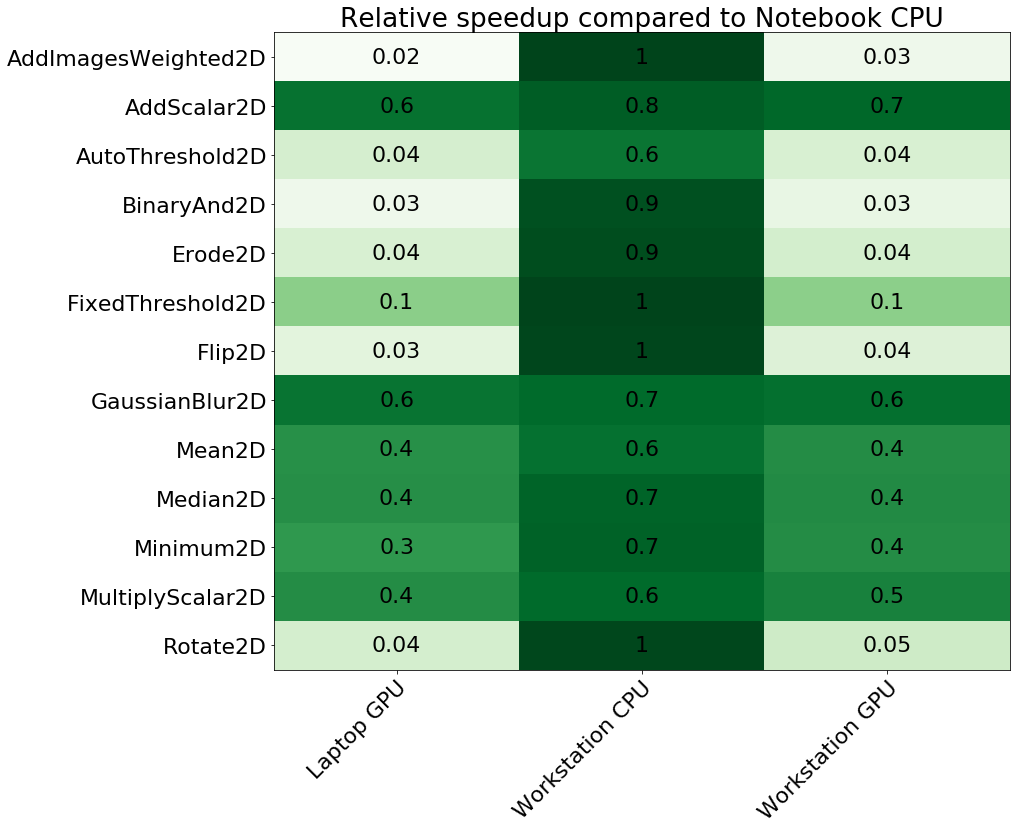

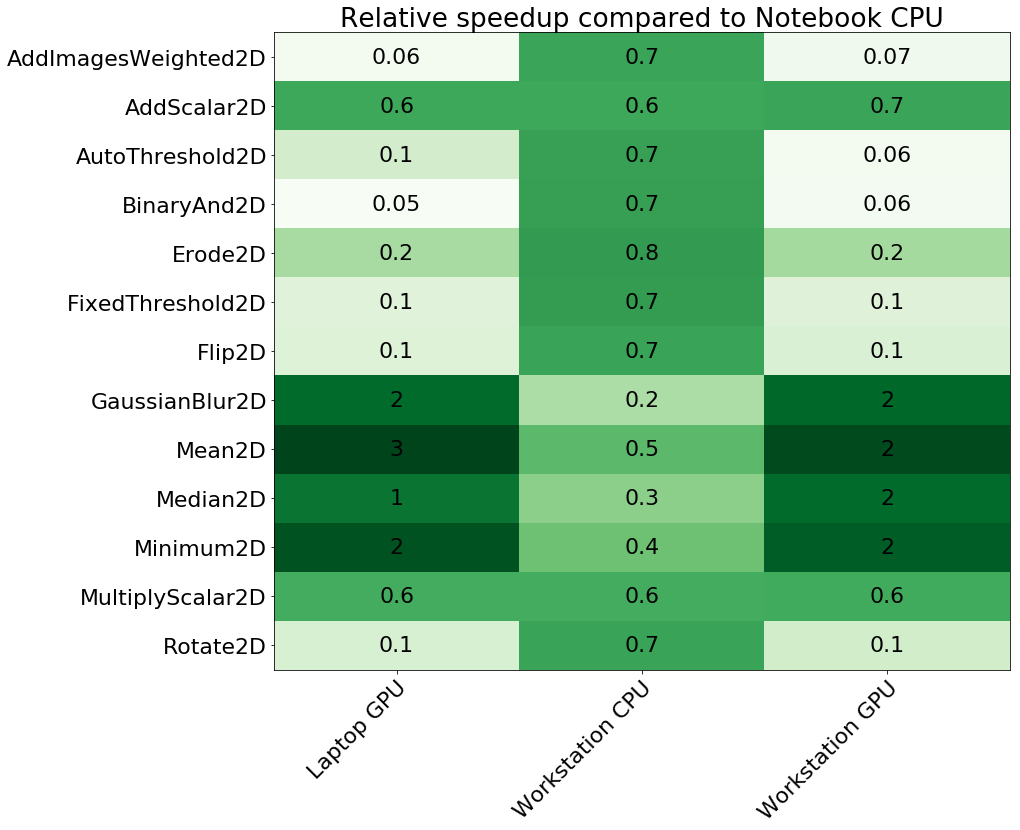

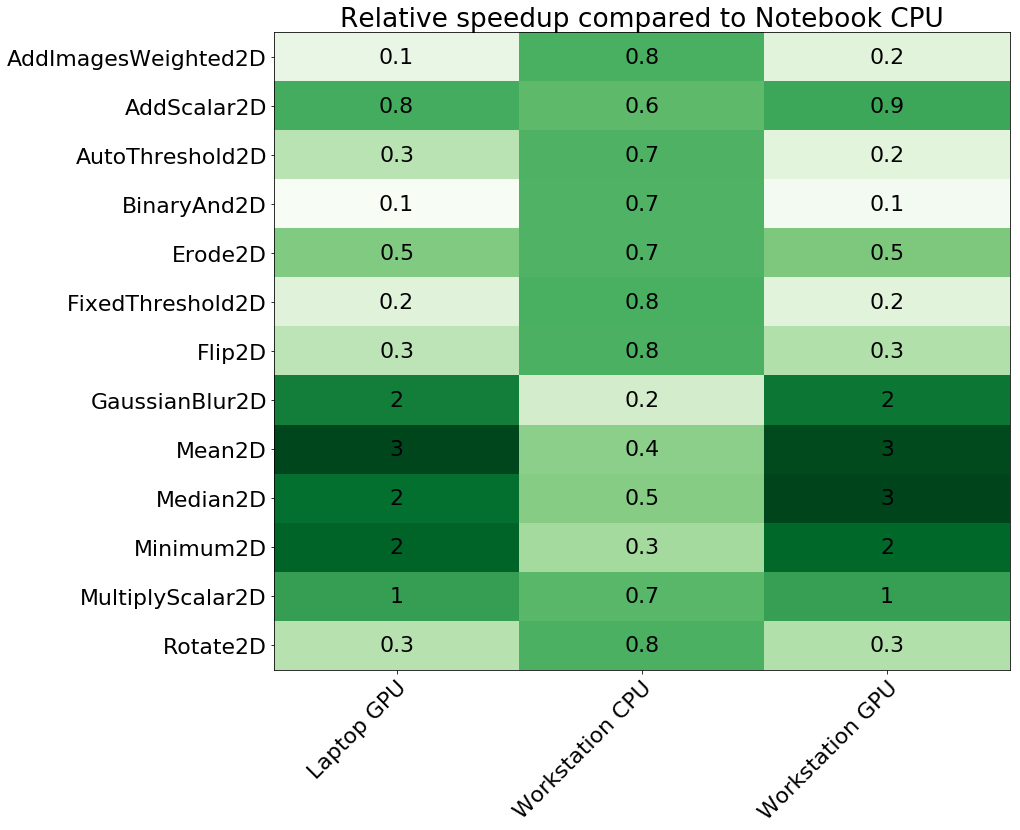

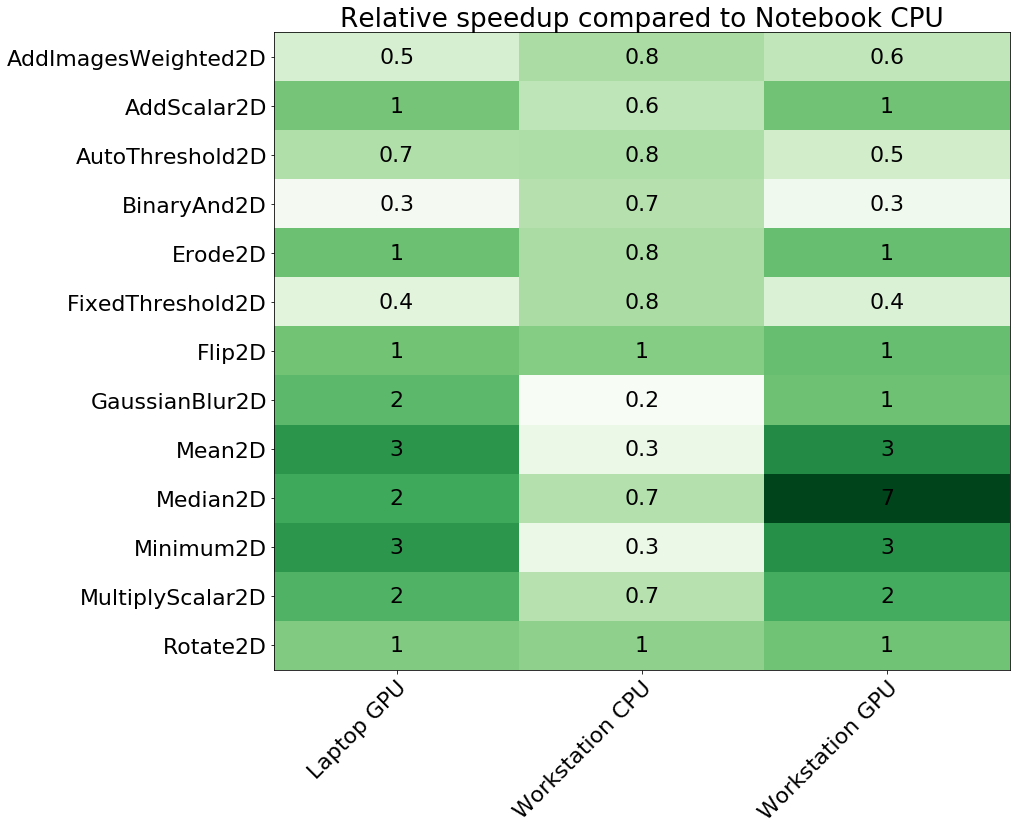

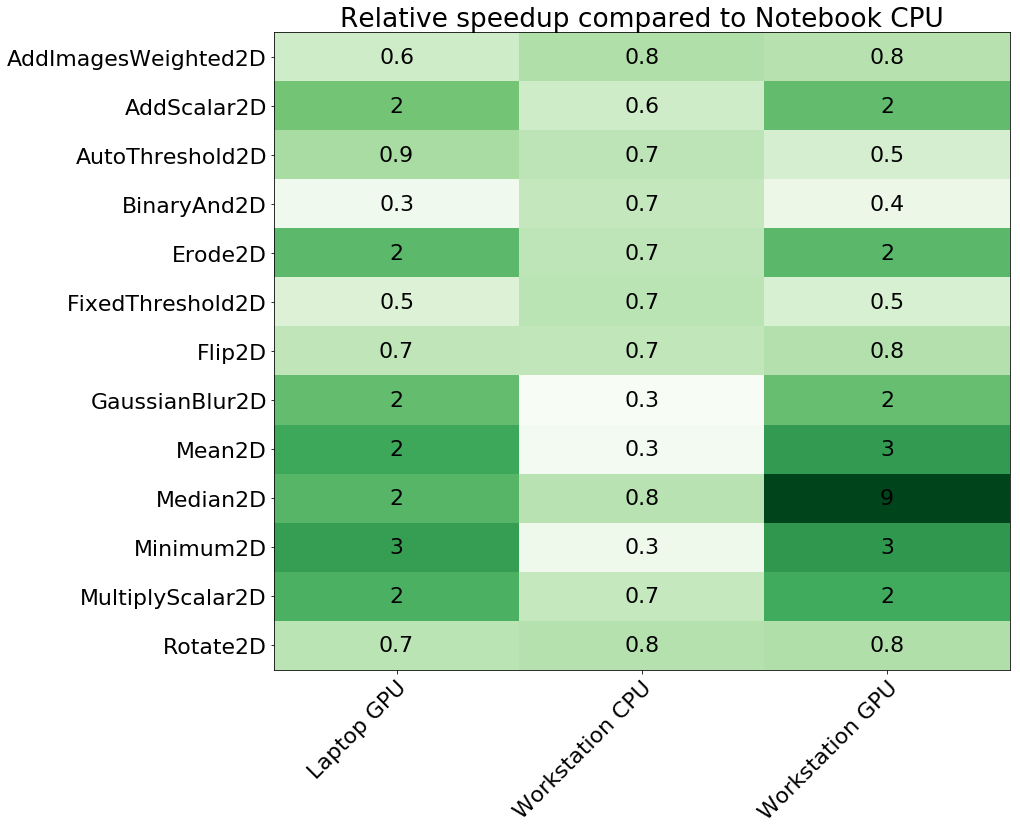

In [59]:
for image_size in range(0, 5):
    save_filename = save_dir + "compare_machines_all_operations_2D_size" + str(image_size)
    drawTable(data_dir, image_size, save_filename, "2D")

0      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted3D.clij
1      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted3D.clij
2      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted3D.clij
3      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted3D.clij
4      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted3D.clij
5      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted3D.clij
6      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted3D.clij
7      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted3D.clij
8      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted3D.clij
9      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted3D.clij
10     net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted3D.clij
11     net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted3D.clij
12     net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted3D.clij
13     net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted3D.clij
0     net.haesleinhuepf.clij.bench

0      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted3D.clij
1      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted3D.clij
2      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted3D.clij
3      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted3D.clij
4      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted3D.clij
5      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted3D.clij
6      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted3D.clij
7      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted3D.clij
8      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted3D.clij
9      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted3D.clij
10     net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted3D.clij
11     net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted3D.clij
12     net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted3D.clij
13     net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted3D.clij
0     net.haesleinhuepf.clij.bench

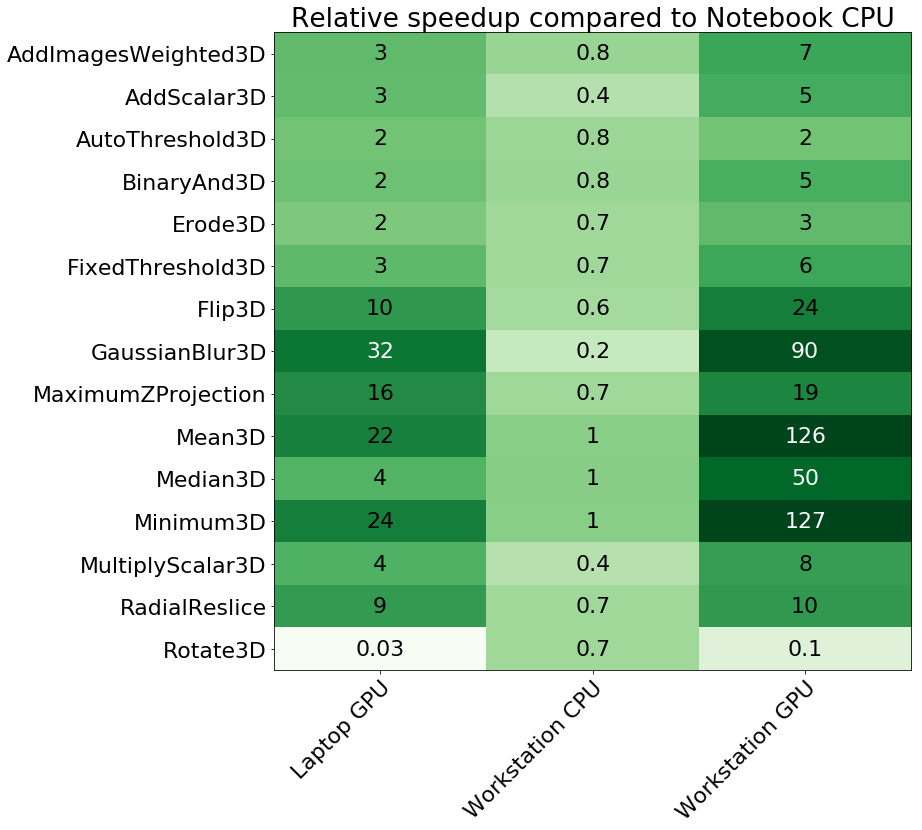

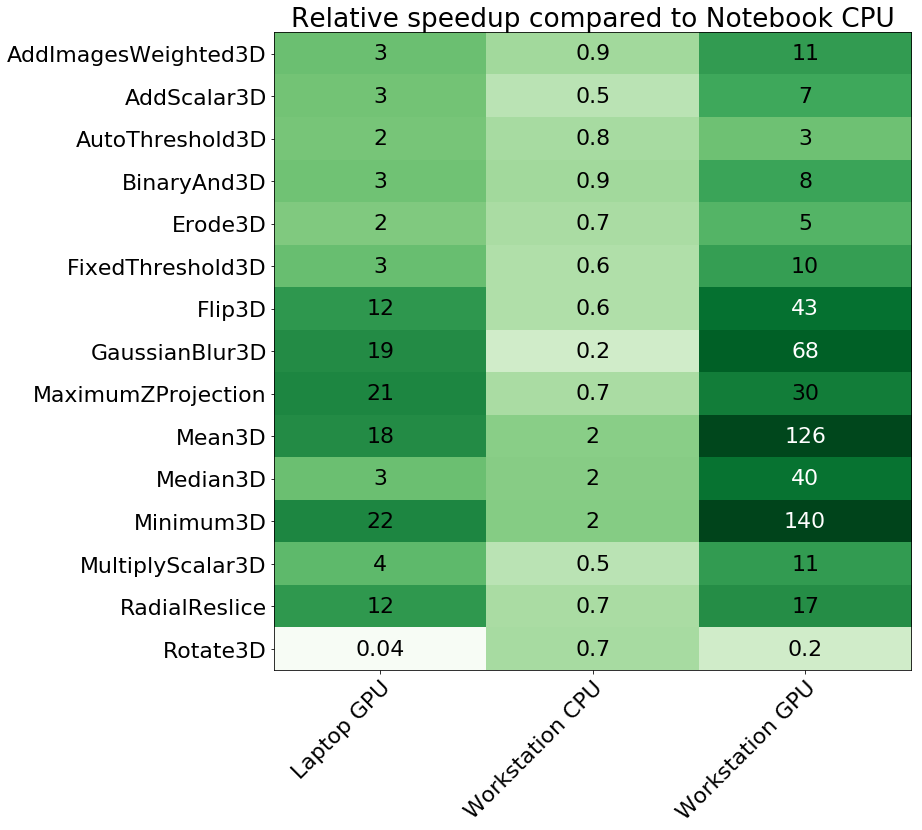

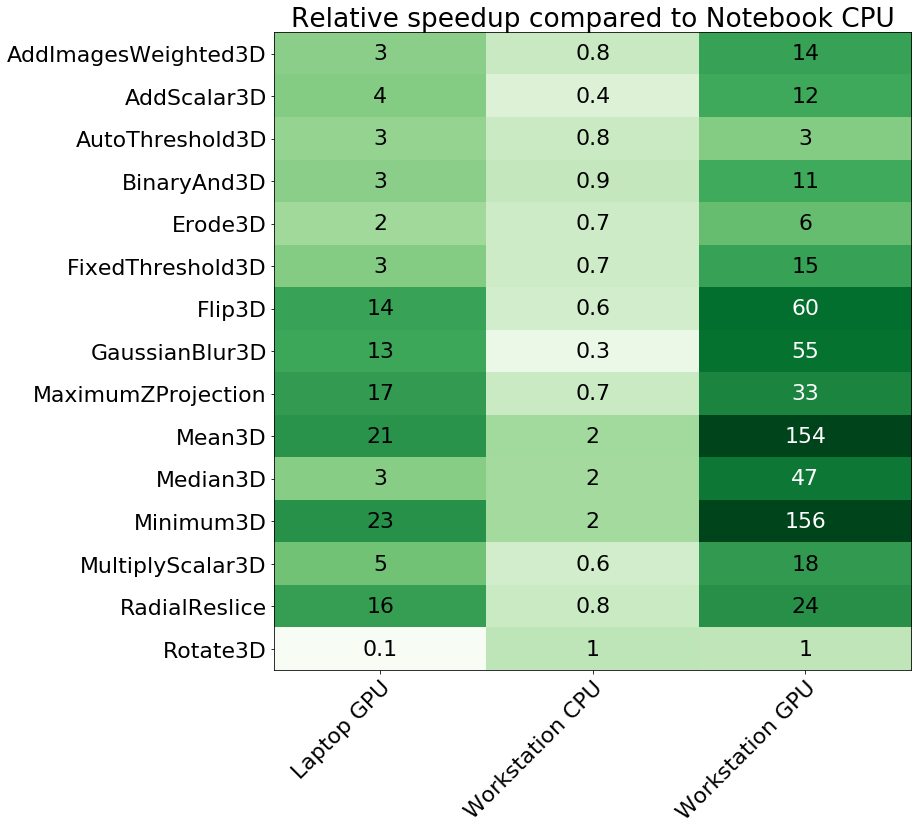

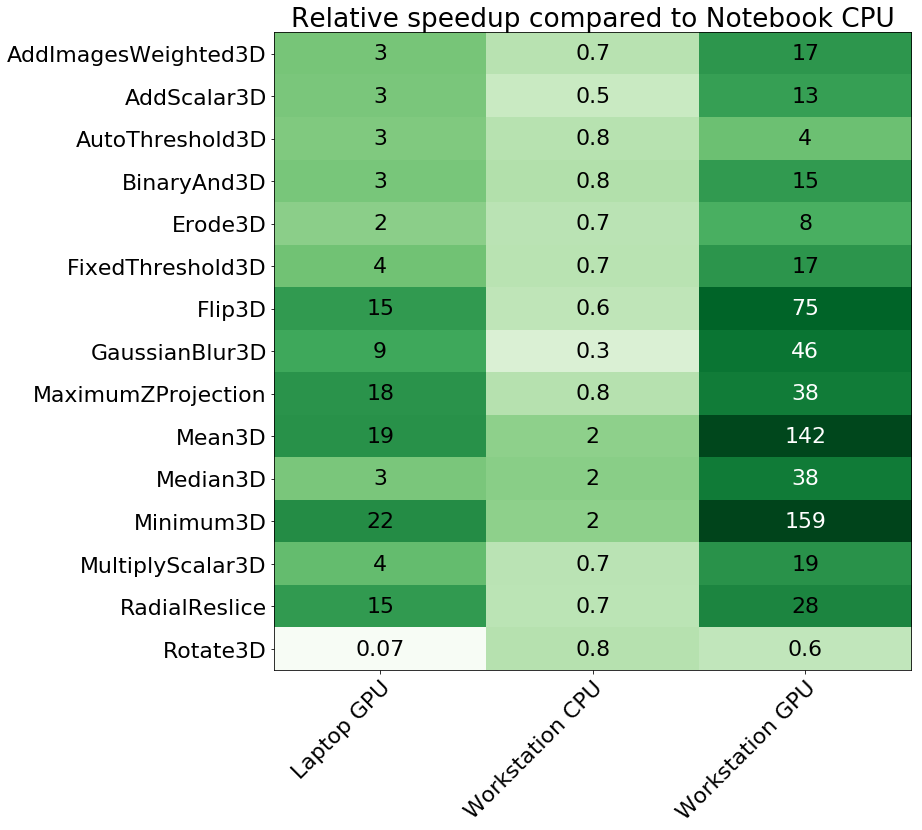

In [60]:
for image_size in range(1, 5):
    save_filename = save_dir + "compare_machines_all_operations_3D_size" + str(image_size)
    drawTable(data_dir, image_size, save_filename, "3D")

0      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
1      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
2      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
3      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
4      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
5      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
6      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
7      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
8      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
9      net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
10     net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
11     net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
12     net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
13     net.haesleinhuepf.clij.benchmark.jmh.AddImagesWeighted2D.clij
0     net.haesleinhuepf.clij.bench

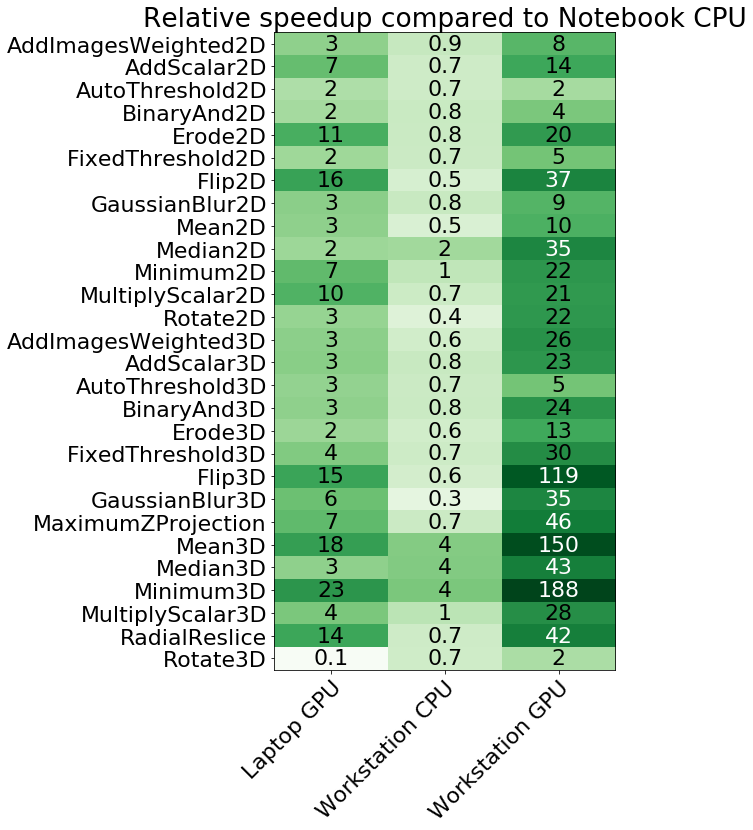

In [62]:
save_filename = save_dir + "compare_machines_all_operations"
drawTable(data_dir, -1, save_filename, "all")